In [102]:
import glob
import os
import pandas as pd
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xlrd
from datetime import date, timedelta, datetime
%matplotlib inline

In [4]:
def process_measure_data():
    path = 'data/SOS/raw'
    all_files = glob.glob(os.path.join(path, "*_measures_*.xls*"))
    df_list = []
    df_meta_list = []
    for infile in all_files:
        print('\n\nReading '+infile)
        # read the excel file into a dataframe, and delete all the empty rows
        df = pd.read_excel(infile)
        df = df.dropna(axis=0,how='all')
        df = df.dropna(axis=1,how='all')

        ### ---------------------------------------
        ### Deal with non-standard formatting
        ### ---------------------------------------

        # this one starts the multicolumn in row 0 instead of row 1. Boo.
        if re.split('/',infile)[-1] == '20031007_measures_statewide-special-election.xls':
            df.iloc[0,1] = df.iloc[0,0]
            df.iloc[0,0] = 'NaN'
            cols = df.columns.values
            cols[1]=cols[0]; cols[0] = 'County';
            df.columns = cols
            df.index = df['County']
            del df['County']

        # this one is formatted completely differently. skip for now.
        if re.split('/',infile)[-1] == '20051108_measures_special-statewide-election.xls':
            continue

        # these ones are just subtly weird... I manually deleted an empty sheet from the first file as well.
        if (re.split('/',infile)[-1] == '20061107_measures_general-election.xls' or
            re.split('/',infile)[-1] == '20081104_measures_presidential-general-election.xls' or 
            re.split('/',infile)[-1] == '20090519_measures_statewide-special-election.xls'):
            df.index = df.iloc[:,0]
            del df[df.columns[0]]

        # this one doesn't label the '  Percent' rows. Need that label for deletion.
        # Also repeats the column headers twice, and the row headers once.
        if re.split('/',infile)[-1] == '20080205_measures_presidential-primary-election.xls':
            del df['Unnamed: 16']
            problem_spots = np.argwhere(df['Proposition No. 91']=='Proposition No. 91').flatten()
            delete_me = [problem_spots[0],problem_spots[0]+1,problem_spots[0]+2,
                         problem_spots[1],problem_spots[1]+1,problem_spots[1]+2]
            df['County'] = df.index
            df.index = np.arange(len(df.index))
            df.drop(labels=df.index[delete_me],axis=0,inplace=True)
            df.index = df['County']
            del df['County']
            index = df.index.values
            for idx,name in enumerate(index[3::2]):
                index[idx*2+3] = '  Percent'
            df.index = index

        # something strange happens in this one.
        if re.split('/',infile)[-1] == '20100608_measures_statewide-direct-primary-election.xls':
            df.index = df.index.get_level_values(0)


        ###----------------------------------
        ### Done with formatting edge cases
        ###----------------------------------

        df.index.name='County'    

        # how many subcolumns per header column do we have? should be 2 or 3 for ballot measure data
        # (either [yes,no] or [yes,no,no vote])
        counter = 0
        for colname in df.columns.values[1:]:
            counter += 1
            if 'Proposition' in colname:
                break
        print('num sub-columns = '+str(counter))
        if counter == 1: counter = 2 # when only one measure

        # get rid of 'No. ', spaces
        cols = df.columns.values
        for idx,col in enumerate(cols):
            cols[idx] = col.replace('No. ','')
            cols[idx] = cols[idx].replace('  ',' ')
            cols[idx] = cols[idx].replace(' ','_')
        df.columns = cols

        # Grab the short description of each proposition
        descriptions = df.iloc[0][::counter]
        # re-index to get rid of initial nan indexers
        index = df.index.values 
        index[0:2]=[0,1]
        df.index = index
        # drop descriptions row, now that we've saved it
        df.drop(labels=df.index[0],axis=0,inplace=True)

        # make a dataframe with election metadata, including ballot measure descriptions...
        df_meta = pd.DataFrame(descriptions)
        df_meta.columns = ['Description']
        # ... and date (not needed anymore because of multiindex)
        #df_meta['Date'] = datetime.strptime(re.search('(\d{8})_',infile).group(1),'%Y%m%d').date()
        # ... and election type
        df_meta['Election_type'] = re.search('measures_([\w\W]*).xls',infile).group(1)

        # easier to drop this and re-engineer, since we have inconsistent data (votes not cast missing in many datasets)
        df.drop(labels='  Percent',inplace=True)

        # drop the 'no vote cast' column if it exists... not as useful if it's not there for all datasets
        # can come up with an approximation using voter registration data if we want
        if counter == 3:
            cols = df.columns.values[2::3]
            df.drop(axis=1,labels=cols,inplace=True)

        # make a MultiIndex for the column headers
        cols = df.columns.values[::2]
        sub_cols = ['Yes','No']
        date_col = pd.DatetimeIndex([datetime.strptime(re.search('(\d{8})_',infile).group(1),'%Y%m%d').date()])
        index=pd.MultiIndex.from_product([date_col,cols,sub_cols],names=['Date','Proposition','Votes'])
        # drop the first row (yes and no), since it's now an index
        df.drop(df.index[0],inplace=True)
        df.columns = index

        # make a MultiIndex for the metadata for easy cross-referencing
        index = pd.MultiIndex.from_product([date_col,cols],names=['Date','Proposition'])
        df_meta.index = index

        # add to lists
        df_list.append(df)
        df_meta_list.append(df_meta)
    
    # combine and save 
    df = pd.concat(df_list,axis=1)
    df.sort_index(axis=1,level=[0,1],inplace=True)
    path = 'data/SOS/processed/measures.csv'
    df.to_csv(path)

    df_meta = pd.concat(df_meta_list,axis=0)
    df_meta.sort_index(inplace=True)
    path_meta = 'data/SOS/processed/measures_metadata.csv'
    df_meta.to_csv(path_meta)

Analgous function for voter registration spreadsheets:

In [81]:
def process_registration_data():
    path = 'data/SOS/raw'
    all_files = glob.glob(os.path.join(path, "*_voter-registration.xls*"))

    df_list = []
    for infile in all_files[0:]:
        print('\n\nReading '+infile)
        # read the excel file into a dataframe, and delete all the empty rows
        df = pd.read_excel(infile,index_col=0)
        df = df.dropna(axis=0,how='all')
        df = df.dropna(axis=1,how='all')

        ### ---------------------------------------
        ### Deal with non-standard formatting
        ### ---------------------------------------

        if 'County' in df.columns.values:
            df.index = df['County']
            del df['County']

        if (re.split('/',infile)[-1] in ['20120103_voter-registration.xls']):
            del df['Unnamed: 14'] # row of totals

        ###----------------------------------
        ### Done with formatting edge cases
        ###----------------------------------

        # standardize column names
        col_names = df.columns.values
        for idx,col in enumerate(col_names):
            col_names[idx] = col.replace('\n ',' ')
            col_names[idx] = col_names[idx].replace(' \n',' ')
            col_names[idx] = col_names[idx].replace('\n',' ')
            if col_names[idx] in ['Declined to State','Decline to State']:
                col_names[idx] = 'No Party Preference'
            elif col_names[idx] == 'Registered':
                col_names[idx] = 'Total Registered'
            elif col_names[idx] == ' * Eligible':
                col_names[idx] = 'Eligible'
        df.columns = col_names

        # sum rare categories into 'All Other' column,
        # then remove (since they don't appear in every dataset)
        rare_col_names = ['Natural Law','Reform','Peace and Freedom',
                          'Americans Elect','Miscellaneous','Other','Unknown']
        other_data = pd.Series(data=np.zeros_like(df.index.values),index=df.index,name='All Other')
        for col in df.columns.values:
            if col in rare_col_names:
                other_data += df[col]
                del df[col]
        df['All Other'] = other_data


        # make a MultiIndex for the column headers
        cols = df.columns.values
        date_col = pd.DatetimeIndex([datetime.strptime(re.search('(\d{8})_',infile).group(1),'%Y%m%d').date()])
        index=pd.MultiIndex.from_product([date_col,cols],names=['Date','Category'])
        df.columns = index

        # make a MultiIndex for the row index: (county,count/pct)
        rows = df.index[::2]
        row_type = ['Count','Fraction']
        index = pd.MultiIndex.from_product([rows,row_type],names=['County','Count_type'])
        df.index = index

        # cross-checks
        # are columns named as expected?
        nominal_index = pd.Index(['All Other', 'American Independent', 'Democratic', 'Eligible', 'Green',
           'Libertarian', 'No Party Preference', 'Republican', 'Total Registered'],
          dtype='object', name='Category')
        if not df.columns.levels[1].equals(nominal_index):
            print('Error: non-standard column names in '+infile)
            print(df.columns.levels[1])
            break


        # add to lists
        df_list.append(df)

    # combine and save 
    df = pd.concat(df_list,axis=1)
    df.sort_index(axis=1,level=[0,1],inplace=True)
    df.sort_index(axis=0,level=[0,1],inplace=True)
    path = 'data/SOS/processed/voter-registration.csv'
    df.to_csv(path)


In [5]:
process_measure_data()



Reading data/SOS/raw/20020305_measures_primary-election.xls
num sub-columns = 3


Reading data/SOS/raw/20021105_measures_general-election.xls
num sub-columns = 3


Reading data/SOS/raw/20031007_measures_statewide-special-election.xls
num sub-columns = 3


Reading data/SOS/raw/20040302_measures_presidential-primary-election.xls
num sub-columns = 2


Reading data/SOS/raw/20041102_measures_presidential-general-election.xls
num sub-columns = 3


Reading data/SOS/raw/20051108_measures_special-statewide-election.xls


Reading data/SOS/raw/20060606_measures_gubernatorial-primary-election.xls
num sub-columns = 3


Reading data/SOS/raw/20061107_measures_general-election.xls
num sub-columns = 2


Reading data/SOS/raw/20080205_measures_presidential-primary-election.xls
num sub-columns = 2


Reading data/SOS/raw/20080603_measures_statewide-direct-primary-election.xls
num sub-columns = 2


Reading data/SOS/raw/20081104_measures_presidential-general-election.xls
num sub-columns = 2


Reading data/

In [82]:
process_registration_data()



Reading data/SOS/raw/20011002_voter-registration.xls


Reading data/SOS/raw/20020104_voter-registration.xls


Reading data/SOS/raw/20020204_voter-registration.xls


Reading data/SOS/raw/20020219_voter-registration.xls


Reading data/SOS/raw/20021007_voter-registration.xls


Reading data/SOS/raw/20021021_voter-registration.xls


Reading data/SOS/raw/20030210_voter-registration.xls


Reading data/SOS/raw/20030808_voter-registration.xls


Reading data/SOS/raw/20030922_voter-registration.xls


Reading data/SOS/raw/20030930_voter-registration.xls


Reading data/SOS/raw/20040102_voter-registration.xls


Reading data/SOS/raw/20040217_voter-registration.xls


Reading data/SOS/raw/20040903_voter-registration.xls


Reading data/SOS/raw/20041018_voter-registration.xls


Reading data/SOS/raw/20050210_voter-registration.xls


Reading data/SOS/raw/20050909_voter-registration.xls


Reading data/SOS/raw/20051024_voter-registration.xls


Reading data/SOS/raw/20060103_voter-registration.xls


Reading 

Test out loading in data and accessing entries and slices

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


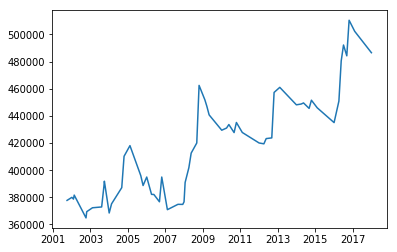

In [107]:
path = 'data/SOS/processed/voter-registration.csv'
df_test = pd.read_csv(path,header=[0,1],index_col=[0,1])
dtIdx = pd.DatetimeIndex(df_test.columns.get_level_values(0))
col_mIdx = pd.MultiIndex.from_arrays([dtIdx,df_test.columns.get_level_values(1)])
df_test.columns = col_mIdx
df_test.sort_index(inplace=True,axis=1,level=[0,1])
df_test.sort_index(axis=1,level=[0,1],inplace=True)
df_test.sort_index(axis=0,level=[0,1],inplace=True)
result = df_test.loc['Alameda',(slice(None),slice('Democratic','Democratic'))].loc['Count']
plt.plot(result.index.get_level_values(0),result)

In [6]:
path = 'data/SOS/processed/measures.csv'
df_test = pd.read_csv(path,header=[0,1,2],index_col=0)
dtIdx = pd.DatetimeIndex(df_test.columns.get_level_values(0))
col_mIdx = pd.MultiIndex.from_arrays([dtIdx,df_test.columns.get_level_values(1),df_test.columns.get_level_values(2)])
df_test.columns = col_mIdx
df_test.sort_index(inplace=True,axis=1,level=[0,1])
df_test.loc[:,'2002']

Date                2002-03-05                                   \
Proposition     Proposition_40          Proposition_41            
Votes                       No      Yes             No      Yes   
Alameda                  74228   142873          81464   130697   
Alpine                     256      281            296      233   
Amador                    5883     3605           5888     3573   
Butte                    25178    21833          24582    24682   
Calaveras                 7642     4923           7642     4763   
Colusa                    2931     1322           2679     1518   
Contra Costa             74344   103748          79849    95390   
Del Norte                 3625     1903           3419     2052   
El Dorado                24884    16872          25075    16173   
Fresno                   53206    53571          50762    54034   
Glenn                     3706     1155           3225     1579   
Humboldt                 16576    15093          16216    14875   
Imperial                  7478     9210           8560     7768   
Inyo                      3297     2217           3100     2305   
Kern                     50046    37754          57589    43359   
Kings                     8046     5821           7932     5755   
Lake                      5881     5372           6102     4988   
Lassen                    5065     2351           4622     2766   
Los Angeles             347804   633273         414154   536127   
Madera                   12143     6565          11473     7068   
Marin                    19960    42222          22778    38257   
Mariposa                  3389     2041           3356     2009   
Mendocino                 7298     8709           9841     9232   
Merced                   14019    12509          14501    12094   
Modoc                     2416      735           2085     1028   
Mono                      1336     1048           1330     1034   
Monterey                 24857    34555          29173    28865   
Napa                     11144    15315          11884    14062   
Nevada                   17307    12884          17329    12199   
Orange                  216770   270153         264208   208619   
Placer                   39972    28446          40883    26942   
Plumas                    4592     2375           4050     2855   
Riverside                79428    96961          85048    94644   
Sacramento               99742   111800         110100    99983   
San Benito                4304     4767           4601     4277   
San Bernardino           79307    84686          83797    77362   
San Diego               191832   233412         209148   207088   
San Francisco            31184   111530          37935   101611   
San Joaquin              43571    43405          45385    40223   
San Luis Obispo          29788    26212          30345    24732   
San Mateo                40094    73921          43941    67588   
Santa Barbara            35037    35126          35937    33007   
Santa Clara              90006   141914         101621   126060   
Santa Cruz               18756    36009          25112    33665   
Shasta                   25445    11588          23512    12911   
Sierra                     973      473            950      478   
Siskiyou                  9035     3285           7978     4265   
Solano                   27106    31100          28281    28615   
Sonoma                   43125    67883          48284    60858   
Stanislaus               34362    35358          37444    31053   
Sutter                    8786     4216           8617     4287   
Tehama                    9124     4601           8764     4806   
Trinity                   3037     1392           2805     1565   
Tulare                   27644    16515          25599    18949   
Tuolumne                  7673     5852           7539     5717   
Ventura                  53433    69671          60585    60059   
Yolo                     14358    20185        

In [108]:
path_meta = 'data/SOS/processed/measures_metadata.csv'
df_test = pd.read_csv(path_meta,header=0,index_col=[0,1])
dtIdx = pd.DatetimeIndex(df_test.index.get_level_values(0))
row_mIdx = pd.MultiIndex.from_arrays([dtIdx,df_test.index.get_level_values(1)])
df_test.index = row_mIdx
df_test.sort_index(inplace=True,axis=0)
df_test.loc['2002',:]

Description  \
Date       Proposition                                                         
2002-03-05 Proposition_40      Clean Water/Air, Safe Parks, Coast Protection   
           Proposition_41              Voting Modernization Bond Act of 2002   
           Proposition_42     Transportation Funding: Sales/Use Tax Revenues   
           Proposition_43                         Right to have vote counted   
           Proposition_44                                    Insurance Fraud   
           Proposition_45    Legislative Term Limits. Local Voter Petitions.   
2002-11-05 Proposition_46           Housing and Emergency Shelter Trust Fund   
           Proposition_47            Kindergarten-University Facilities Bond   
           Proposition_48                                Court Consolidation   
           Proposition_49                After School Programs. State Grants   
           Proposition_50    Water Quality, Supply/Safe Drinking Water Bonds   
           Proposition_51  Transportation. Allocation of Motor Vehicle Taxes   
           Proposition_52                    Election Day Voter Registration   

                              Election_type  
Date       Proposition                       
2002-03-05 Proposition_40  primary-election  
           Proposition_41  primary-election  
           Proposition_42  primary-election  
           Proposition_43  primary-election  
           Proposition_44  primary-election  
           Proposition_45  primary-election  
2002-11-05 Proposition_46  general-election  
           Proposition_47  general-election  
           Proposition_48  general-election  
           Proposition_49  general-election  
           Proposition_50  general-election  
           Proposition_51  general-election  
           Proposition_52  general-election

In [109]:
idx = pd.IndexSlice
df_test.loc[idx[:,['Proposition_50']],:]

,,Description,Election_type
Date,Proposition,,
2002-11-05,Proposition_50,"Water Quality, Supply/Safe Drinking Water Bonds",general-election
2016-06-07,Proposition_50,Suspension \nof Legislators.,presidential-primary-election
